In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model_name = "ollieturnbull/p-IgGen"
df = load_dataset("ginkgo-datapoints/GDPa1")["train"].to_pandas()

# Example: Just predict HIC, so we'll drop NaN rows for that
df = df.dropna(subset=["HIC"])
df.head()

antibody_id antibody_name   Titer  Purity  SEC %Monomer   SMAC    HIC  \
0   GDPa1-001    abagovomab  140.25  98.530        97.010  2.730  2.590   
1   GDPa1-002    abituzumab  193.31  99.825        97.620  2.745  2.545   
2   GDPa1-003   abrezekimab  114.75  98.350        89.055  2.740  2.705   
3   GDPa1-004     abrilumab  327.32  98.575        98.605  2.715  2.565   
4   GDPa1-005    adalimumab  313.39  99.300        96.120  2.705  2.495   

     HAC    PR_CHO    PR_Ova  ...  \
0    NaN  0.337837  0.263108  ...   
1  3.690  0.205246  0.100155  ...   
2    NaN  0.138773  0.101180  ...   
3  1.005  0.000000  0.054971  ...   
4    NaN  0.183387  0.085628  ...   

                                 hc_protein_sequence  \
0  MRAWIFFLLCLAGRALAQVKLQESGAELARPGASVKLSCKASGYTF...   
1  MRAWIFFLLCLAGRALAQVQLQQSGGELAKPGASVKVSCKASGYTF...   
2  MRAWIFFLLCLAGRALAQVTLKESGPVLVKPTETLTLTCTVSGFSL...   
3  MRAWIFFLLCLAGRALAQVQLVQSGAEVKKPGASVKVSCKVSGYTL...   
4  MRAWIFFLLCLAGRALAEVQLVESGGGLVQPGRSLRLSCAASGFTF...   

                                     hc_dna_sequence  \
0  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
1  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
2  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
3  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
4  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   

                                 vl_protein_sequence  \
0  DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQL...   
1  DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...   
2  DIQMTQSPSSLSASVGDRVTITCLASEDISNYLAWYQQKPGKAPKL...   
3  DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKL...   
4  DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKL...   

                                 lc_protein_sequence  \
0  MRAWIFFLLCLAGRALADIELTQSPASLSASVGETVTITCQASENI...   
1  MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQDI...   
2  MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCLASEDI...   
3  MRAWIFFLLCLAGRALADIQMTQSPSSVSASVGDRVTITCRASQGI...   
4  MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQGI...   

                                     lc_dna_sequence  \
0  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
1  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
2  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
3  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   
4  GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...   

  hierarchical_cluster_fold random_fold  \
0                         1           2   
1                         1           4   
2                         2           2   
3                         1           3   
4                         0           2   

  hierarchical_cluster_IgG_isotype_stratified_fold  \
0                                                2   
1                                                0   
2                                                2   
3                                                0   
4                                                0   

                                   light_aligned_aho  \
0  DIELTQSPASLSASVGETVTITCQAS--ENIY------SYLAWHQQ...   
1  DIQMTQSPSSLSASVGDRVTITCRAS--QDIS------NYLAWYQQ...   
2  DIQMTQSPSSLSASVGDRVTITCLAS--EDIS------NYLAWYQQ...   
3  DIQMTQSPSSVSASVGDRVTITCRAS--QGIS------SWLAWYQQ...   
4  DIQMTQSPSSLSASVGDRVTITCRAS--QGIR------NYLAWYQQ...   

                                   heavy_aligned_aho  
0  QVKLQES-GAELARPGASVKLSCKASG-YTFTN-----YWMQWVKQ...  
1  QVQLQQS-GGELAKPGASVKVSCKASG-YTFSS-----FWMHWVRQ...  
2  QVTLKES-GPVLVKPTETLTLTCTVSG-FSLTN-----YHVQWIRQ...  
3  QVQLVQS-GAEVKKPGASVKVSCKVSG-YTLSD-----LSIHWVRQ...  
4  EVQLVES-GGGLVQPGRSLRLSCAASG-FTFDD-----YAMHWVRQ...  

[5 rows x 30 columns]

In [ ]:
# Tokenize the sequences
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Paired sequence handling: Concatenate heavy and light chains and add beginning ("1") and end ("2") tokens 
# (e.g. ["EVQLV...", "DIQMT..."] -> "1E V Q L V ... D I Q M T ... 2")
sequences = [
    "1" + " ".join(heavy) + " ".join(light) + "2"
    for heavy, light in zip(
        df["vh_protein_sequence"],
        df["vl_protein_sequence"],
    )
]

print(sequences[0])

1Q V K L Q E S G A E L A R P G A S V K L S C K A S G Y T F T N Y W M Q W V K Q R P G Q G L D W I G A I Y P G D G N T R Y T H K F K G K A T L T A D K S S S T A Y M Q L S S L A S E D S G V Y Y C A R G E G N Y A W F A Y W G Q G T T V T V S SD I E L T Q S P A S L S A S V G E T V T I T C Q A S E N I Y S Y L A W H Q Q K Q G K S P Q L L V Y N A K T L A G G V S S R F S G S G S G T H F S L K I K S L Q P E D F G I Y Y C Q H H Y G I L P T F G G G T K L E I K2


In [ ]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# Takes about 60 seconds for 242 sequences on my CPU, and 1.1s on GPU
batch_size = 16
mean_pooled_embeddings = []
for i in tqdm(range(0, len(sequences), batch_size)):
    batch = tokenizer(sequences[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
    outputs = model(batch["input_ids"].to(device), return_rep_layers=[-1], output_hidden_states=True)
    embeddings = outputs["hidden_states"][-1].detach().cpu().numpy()
    mean_pooled_embeddings.append(embeddings.mean(axis=1))
mean_pooled_embeddings = np.concatenate(mean_pooled_embeddings)

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
# Train a linear regression on these
X = mean_pooled_embeddings
y = df[["HIC"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = Ridge()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

In [23]:
# Calculate score
spearmanr(y_pred, y_test)

SignificanceResult(statistic=np.float64(0.436477769713997), pvalue=np.float64(0.0017165045450545625))

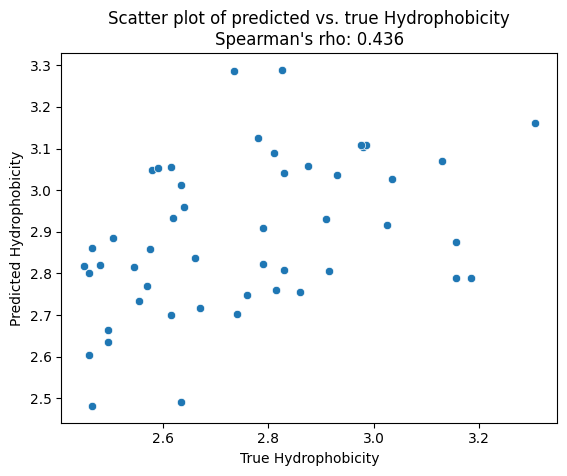

In [ ]:
sns.scatterplot(x=y_test[:, 0], y=y_pred[:, 0])
plt.title(f"Scatter plot of predicted vs. true Hydrophobicity\nSpearman's rho: {spearmanr(y_pred, y_test)[0]:.2f}")
plt.xlabel("True Hydrophobicity")
plt.ylabel("Predicted Hydrophobicity")
plt.show()

## Cross-validation

In [ ]:
# TODO same as above but using hierarchical_cluster_IgG_isotype_stratified_fold